<a href="https://colab.research.google.com/github/Guo-Weiqiang/Master-Project/blob/main/baseline(EEGNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import torch
from torch.autograd import Variable
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch.optim as optim
import pandas as pd
from torchsummary import summary
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR
from torch.nn import init
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid


# reproducible
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIGMA = 1

def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)

TODO
- literature study, online?
- template, num of pages
- train, val(s+t), test, MK-MMD
- experiments (TCA, DANN, Ours)
- Datasets acquisition
- t-sne
- multi-source
- task transfer

- t sne plot(s/t domain, 不同的类不同颜色的点)
- DaNN
- Dataset(SEED)
- multi-source
- task transfer

```
# This is formatted as code
```




# Loss Part




In [2]:
# 1. 成熟的数据集上，与主流的结果比（调整一下架构）
# 2. EEGNet 回归问题
# 3. 联合分布

# *. 可视化 t-sne 看看adapt之后的数据分布


# def MMD(source, target):
# 	"""
# 	mmd loss(linear)
# 	:param source: torch tensor: source data (Ds) with dimensions DxNs
# 	:param target: torch tensor: target data (Dt) with dimensons DxNt
# 	"""
# 	delta = source - target
# 	loss = torch.mean(torch.mm(delta, torch.transpose(delta, 0, 1)))

# 	return loss


# ref.
# 1. https://github.com/thuml/Xlearn/blob/master/pytorch/src/loss.py
# 2. https://github.com/MaterialsInformaticsDemo/DAN/blob/main/code/MK_MMD.py
# 3. https://github.com/thuml/Transfer-Learning-Library/blob/master/tllib/alignment/dan.py
def gaussian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    # The simplest version: K = \beta * k where \beta=1
    n_samples_source = source.size(0)
    n_samples_target = target.size(0)
    total = torch.cat([source, target], dim=0)

    # Calculate the L2 distance matrix efficiently using matrix operations.
    total_xx = torch.sum(total * total, dim=1, keepdim=True)
    L2_distance = total_xx - 2.0 * torch.matmul(total, total.t()) + total_xx.t()
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        # Set the average value of distance matrix as the bandwidth
        bandwidth = torch.sum(L2_distance.data) / (n_samples_source * n_samples_target - n_samples_source)

    bandwidth /= kernel_mul ** (kernel_num // 2) #
    # bandwidth range [2^{-4}*sigma, 2^4*sigma]
    bandwidth_list = [bandwidth * (kernel_mul ** (1 * i)) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]

    return sum(kernel_val) # final gaussian kernel matrix



def MK_MMD(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=1.68): # fix_sigma from None to 1.68
    n_s, n_t = source.size(0), target.size(0)

    kernels = gaussian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)

    # Efficiently calculate loss components using vectorized operations.
    SS = torch.triu(kernels[:n_s, :n_s], diagonal=1).sum() / float(n_s * n_s)
    TT = torch.triu(kernels[-n_t:, -n_t:], diagonal=1).sum() / float(n_t * n_t)
    ST = -kernels[:n_s, -n_t:].sum() / float(n_s * n_t)
    TS = -kernels[-n_t:, :n_s].sum() / float(n_s * n_t)

    loss = torch.abs(SS + TT - ST - TS)

    # return loss
    # loss1 = torch.triu(kernels[:batch_size, :batch_size], diagonal=1).sum() + torch.triu(kernels[batch_size:, batch_size:], diagonal=1).sum()
    # loss1 = loss1 / float(batch_size * batch_size / 2)

    # loss2 = -kernels[:batch_size, batch_size:].sum() - kernels[batch_size:, :batch_size].sum()
    # loss2 = loss2 / float(batch_size * batch_size)

    return loss

def MMD(Xs, Xt):
    ns, nt = Xs.size(0), Xt.size(0)

    # linear kernel version
    mmd_s = (Xs @ Xs.t()).sum() / (ns * ns)
    mmd_t = (Xt @ Xt.t()).sum() / (nt * nt)
    mmd_st = (Xs @ Xt.t()).sum() * 2.0 / (ns * nt)
    loss = mmd_s - mmd_st + mmd_t

    return torch.abs(loss)


def JMMD_Linear(source_list, target_list, kernel_muls=[2.0, 2.0, 2.0], kernel_nums=[5, 5, 1], fix_sigma_list=[None, None, 1.68]):
    batch_size = int(source_list[0].size()[0])
    layer_num = len(source_list)
    joint_kernels = None
    for i in range(layer_num):
        source = source_list[i]
        target = target_list[i]
        kernel_mul = kernel_muls[i]
        kernel_num = kernel_nums[i]
        fix_sigma = fix_sigma_list[i]
        kernels = gaussian_kernel(source, target,
            kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
        if joint_kernels is not None:
            joint_kernels = joint_kernels * kernels
        else:
            joint_kernels = kernels

    # Linear version
    # loss = 0
    # for i in range(batch_size):
    #     s1, s2 = i, (i+1) % batch_size
    #     t1, t2 = s1 + batch_size, s2 + batch_size
    #     loss += joint_kernels[s1, s2] + joint_kernels[t1, t2]
    #     loss -= joint_kernels[s1, t2] + joint_kernels[s2, t1]

    s1 = torch.arange(batch_size)
    s2 = (s1 + 1) % batch_size
    t1 = s1 + batch_size
    t2 = s2 + batch_size

    # Compute the loss in a vectorized way
    loss = torch.sum(joint_kernels[s1, s2] + joint_kernels[t1, t2] - joint_kernels[s1, t2] - joint_kernels[s2, t1])
    return torch.abs(loss) / float(batch_size) # loss might be negative



def _primal_kernel(Xs, Xt):
    Z = torch.cat((Xs.T, Xt.T), 1)  # Xs / Xt: batch_size * k
    return Z


def _linear_kernel(Xs, Xt):
    Z = torch.cat((Xs, Xt), 0)  # Xs / Xt: batch_size * k
    K = torch.mm(Z, Z.T)
    return K


def _rbf_kernel(Xs, Xt, sigma):
    if Xs.ndim == 1:
        Xs = Xs.unsqueeze(1)
    if Xt.ndim == 1:
        Xt = Xt.unsqueeze(1)
    Z = torch.cat((Xs, Xt), 0)
    ZZT = torch.mm(Z, Z.T)
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.T
    K = torch.exp(-exponent / (2 * sigma ** 2))
    return K

# functions to compute the marginal MMD with rbf kernel
def rbf_mmd(Xs, Xt, sigma):
    device = Xs.device

    K = _rbf_kernel(Xs, Xt, sigma)
    m = Xs.size(0)  # assume Xs, Xt are same shape
    e = torch.cat((1 / m * torch.ones(m, 1), -1 / m * torch.ones(m, 1)), 0).to(device)
    M = e * e.T
    tmp = torch.mm(torch.mm(K, M), K.T)
    loss = torch.trace(tmp).to(device)
    return loss

# functions to compute rbf kernel JMMD
def rbf_jmmd(Xs, Ys, Xt, Yt0, sigma):
    device = Xs.device

    K = _rbf_kernel(Xs, Xt, sigma)
    n = K.size(0)
    m = Xs.size(0)  # assume Xs, Xt are same shape
    e = torch.cat((1 / m * torch.ones(m, 1), -1 / m * torch.ones(m, 1)), 0).to(device)
    C = len(torch.unique(Ys))
    M = e * e.T * C
    for c in torch.unique(Ys):
        e = torch.zeros(n, 1, device=device)
        e[:m][Ys == c] = 1 / len(Ys[Ys == c])
        if len(Yt0[Yt0 == c]) == 0:
            e[m:][Yt0 == c] = 0
        else:
            e[m:][Yt0 == c] = -1 / len(Yt0[Yt0 == c])
        M = M + e * e.T
    M = M / torch.norm(M, p='fro')  # can reduce the training loss only for jmmd
    tmp = torch.mm(torch.mm(K, M), K.T)
    loss = torch.trace(tmp).to(device)
    return loss


def rbf_jpmmd(Xs, Ys, Xt, Yt0, sigma):
    device = Xs.device

    K = _rbf_kernel(Xs, Xt, sigma)
    n = K.size(0)
    m = Xs.size(0)  # assume Xs, Xt are same shape
    M = 0
    for c in torch.unique(Ys):
        e = torch.zeros(n, 1, device=device)
        e[:m] = 1 / len(Ys)
        if len(Yt0[Yt0 == c]) == 0:
            e[m:] = 0
        else:
            e[m:] = -1 / len(Yt0)
        M = M + e * e.T
    tmp = torch.mm(torch.mm(K, M), K.T)
    loss = torch.trace(tmp).to(device)
    return loss


# functions to compute rbf kernel DJP-MMD
def rbf_djpmmd(Xs, Ys, Xt, Yt0, sigma):
    # Assuming _rbf_kernel is already optimized and running on the correct device
    K = _rbf_kernel(Xs, Xt, sigma)
    m, C = Xs.size(0), 2  # Assuming number of classes C is fixed at 2

    # Ensure all tensors start on the same device, ideally on the GPU if available
    device = Xs.device
    Ns = torch.zeros(m, C, device=device).scatter_(1, Ys.unsqueeze(1), 1) / m
    Nt = torch.zeros(m, C, device=device)
    if len(torch.unique(Yt0)) == 1:
        Nt = torch.zeros(m, C, device=device).scatter_(1, Yt0.unsqueeze(1), 1) / m

    Rmin_1 = torch.cat((torch.mm(Ns, Ns.T), torch.mm(-Ns, Nt.T)), 0)
    Rmin_2 = torch.cat((torch.mm(-Nt, Ns.T), torch.mm(Nt, Nt.T)), 0)
    Rmin = torch.cat((Rmin_1, Rmin_2), 1)

    # For discriminability
    Ms = torch.empty(m, (C - 1) * C).to(device)
    Mt = torch.empty(m, (C - 1) * C).to(device)
    for i in range(0, C):
        idx = torch.arange((C - 1) * i, (C - 1) * (i + 1))
        Ms[:, idx] = Ns[:, i].repeat(C - 1, 1).T
        tmp = torch.arange(0, C)
        Mt[:, idx] = Nt[:, tmp[tmp != i]]
    Rmax_1 = torch.cat((torch.mm(Ms, Ms.T), torch.mm(-Ms, Mt.T)), 0)
    Rmax_2 = torch.cat((torch.mm(-Mt, Ms.T), torch.mm(Mt, Mt.T)), 0)
    Rmax = torch.cat((Rmax_1, Rmax_2), 1)

    M = Rmin - 0.1 * Rmax
    # M = Rmin + Rmax
    # Operate in the same device as K and M to avoid device transfers
    tmp = torch.mm(torch.mm(K, M), K.T).to(device)
    loss = torch.trace(tmp)

    return loss


def compute_sigma(H):
    dists = torch.pdist(H)
    sigma = dists.median() / 2

    return sigma.detach()

def GaussianMatrix(X, Y, sigma, if_use_cdist=False, median_sigma = False):
    if not if_use_cdist:
        size1 = X.size()
        size2 = Y.size()
        G = (X*X).sum(-1)
        H = (Y*Y).sum(-1)
        Q = G.unsqueeze(-1).repeat(1,size2[0])
        R = H.unsqueeze(-1).T.repeat(size1[0],1)
        # print(G.shape, R.shape, X.shape, Y.shape, Q.shape, R.shape)
        H = Q + R - 2 * X @ (Y.T)
    else:
        H = torch.cdist(X, Y, p=2) ** 2

    if sigma > 0:
        H = torch.exp(-H / 2 / sigma ** 2)
    else:
        if median_sigma:
            sigma = compute_sigma(H)
            H = torch.exp(-H / 2 / sigma / 2)
        else:
            sigma = H.mean().detach()
            H = torch.exp(-H / sigma)

    return H



# CKB loss
def CCS(x1, x2, y1, y2, sigma=1, if_use_cdist=False, median_sigma=False):
    # Input: N x d

    # K1 = GaussianMatrix(x1, x1, sigma, if_use_cdist, median_sigma) # a lot of 0 (1560)
    K1 = _rbf_kernel(x1, x1, sigma)
    # print('K1', K1)

    # K2 = GaussianMatrix(x2, x2, sigma, if_use_cdist, median_sigma) # 1560 0
    K2 = _rbf_kernel(x2, x2, sigma)
    # print('K2', K2)
    # L1 = GaussianMatrix(y1, y1, sigma, if_use_cdist, median_sigma)
    L1 = _rbf_kernel(y1, y1, sigma)
    # print('L1', L1)
    # L2 = GaussianMatrix(y2, y2, sigma, if_use_cdist, median_sigma)
    L2 = _rbf_kernel(y2, y2, sigma)
    # print('L2', L2)

    #print(x1.shape, x2.shape, y1.shape, y2.shape, K1.shape, K2.shape, L1.shape, L2.shape)

    # K12 = GaussianMatrix(x1, x2, sigma, if_use_cdist, median_sigma) # nan happens  1600 0 ---> all zeros --> makes the later part nan
    # L12 = GaussianMatrix(y1, y2, sigma, if_use_cdist, median_sigma) #
    K12 = _rbf_kernel(x1, x2, sigma)
    L12 = _rbf_kernel(y1, y2, sigma)
    # print('K12', K12)
    # print('L12', L12)
    # print('K12*L12', K12 * L12)

    # K21 = GaussianMatrix(x2, x1, sigma, if_use_cdist, median_sigma) # nan happens  1600 0
    # L21 = GaussianMatrix(y2, y1, sigma, if_use_cdist, median_sigma)
    K21 = _rbf_kernel(x2, x1, sigma)
    L21 = _rbf_kernel(y2, y1, sigma)
    # print('K21', K21)
    # print('L21', L21)
    # print('K21*L21', K21 * L21)

    H1 = K1 * L1 # 1560 0
    self_term1 = (H1.sum(-1) / ((K1.sum(-1)) ** 2)).sum(0) #
    assert not torch.isnan(self_term1).any(), "self_term1 contains NaN"

    H2 = K2 * L2
    self_term2 = (H2.sum(-1) / ((K2.sum(-1)) ** 2)).sum(0)
    assert not torch.isnan(self_term2).any(), 'self_term2 contains NaN'

    ##################################DEBUG#################################################
    H3 = K12 * L12
    cross_term1 = (H3.sum(-1) / ((K1.sum(-1)) * (K12.sum(-1)))).sum(0)# # nan first happens
    # print('1', H3.sum(-1))
    # print('2', ((K1.sum(-1)) * (K12.sum(-1))))
    # print('3', (H3.sum(-1) / ((K1.sum(-1)) * (K12.sum(-1)))))
    # print(cross_term1)
    assert not torch.isnan(cross_term1).any(), 'cross_term1 contains NaN'
    ##################################DEBUG################################################
    H4 = K21 * L21
    cross_term2 = (H4.sum(-1) / ((K2.sum(-1))*(K21.sum(-1)))).sum(0)
    assert not torch.isnan(cross_term1).any(), 'cross_term2 contains NaN'
    # print(cross_term1.item(), cross_term2.item(), self_term1.item(), self_term2.item())

    # cs1 = -2*torch.log(cross_term1) + torch.log(self_term1) + torch.log(self_term2)
    # cs2 = -2*torch.log(cross_term2) + torch.log(self_term1) + torch.log(self_term2)
    ccs = -torch.log(cross_term1 + 1e-10) - torch.log(cross_term2 + 1e-10) + torch.log(self_term1 + 1e-10) + torch.log(self_term2 + 1e-10)


    return ccs

def CS(x1, x2, sigma = 10, if_use_cdist=False, median_sigma=False):
    K1 = GaussianMatrix(x1, x1, sigma, if_use_cdist, median_sigma)
    K2 = GaussianMatrix(x2, x2, sigma, if_use_cdist, median_sigma)

    K12 = GaussianMatrix(x1, x2, sigma, if_use_cdist, median_sigma)

    # K1 = _rbf_kernel(x1, x1, sigma)
    # K2 = _rbf_kernel(x2, x2, sigma)
    # K12 = _rbf_kernel(x1, x2, sigma)

    dim1 = K1.shape[0]
    self_term1 = K1.sum() / (dim1**2)

    dim2 = K2.shape[0]
    self_term2 = K2.sum() / (dim2**2)

    cross_term = K12.sum() / (dim1*dim2)

    cs =  -2 * torch.log(cross_term + 1e-10) + torch.log(self_term1 + 1e-10) + torch.log(self_term2 + 1e-10)

    return cs

# 1. Model Part

In [3]:


# ref.
# 1. https://github.com/agrija9/Deep-Unsupervised-Domain-Adaptation/blob/master/DDC/model.py
class EEGNet_ReLU(torch.nn.Module):
    def __init__(self, n_output):
        super(EEGNet_ReLU, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten()
        )
        self.classify = nn.Sequential(
            # nn.Linear(736, 256),
            # nn.ReLU(inplace=True),
            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True),
            # nn.Linear(256, n_output, bias=True)

            # original classifier
            nn.Linear(736, n_output, bias=True)
        )

    def forward(self, x):
        out = self.firstConv(x)
        out = self.depthwiseConv(out)
        features = self.separableConv(out)
        out = self.classify(features)
        return out, features




class EEGNet_DDC(nn.Module):
    """
    Deep domain confusion network as defined in the paper:
    https://arxiv.org/abs/1412.3474
        :param num_classes: int
    """
    def __init__(self, num_classes):
        super(EEGNet_DDC, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten(),
        )

        # Ref. bottleneck in the paper
        # Our intuition is that a lower dimensional layer can be used to regularize the training of the source classiﬁer and prevent overﬁtting to the particular nuances of the source distribution
        self.bottleneck = nn.Sequential(
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)
            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(256, num_classes, bias=True)
        )

        # # fc8 activation (final_classifier)
        # # self.fc8 = nn.Linear(736, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Linear(256, num_classes, bias=True)
        # )

    def forward(self, source, target):
        source = self.firstConv(source)
        source = self.depthwiseConv(source)
        features_src = self.separableConv(source)
        source = self.bottleneck(features_src)
        # print(source.shape)

        mmd_loss = 0
        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        features_tar = self.separableConv(target)
        target = self.bottleneck(features_tar)
        # print(target.shape)
        mmd_loss += MMD(source, target)

        result = self.classifier(source)

        return result, mmd_loss, source, target


class EEGNet_DAN(nn.Module):
    """
    Deep domain confusion network as defined in the paper:
    https://arxiv.org/abs/1412.3474
        :param num_classes: int
    """
    def __init__(self, num_classes):
        super(EEGNet_DAN, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten()
        )

        # Ref. bottleneck in the paper
        # Our intuition is that a lower dimensional layer can be used to regularize the training of the source classiﬁer and prevent overﬁtting to the particular nuances of the source distribution
        self.bottleneck1 = nn.Sequential(
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)

            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True)
        )
        self.bottleneck2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(256, num_classes, bias=True)
        )

        # # fc8 activation (final_classifier)
        # # self.fc8 = nn.Linear(736, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Linear(256, num_classes, bias=True)
        # )

    def forward(self, source, target):
        source = self.firstConv(source)
        source = self.depthwiseConv(source)
        source = self.separableConv(source)
        f1_s = self.bottleneck1(source)
        f2_s = self.bottleneck2(f1_s)
        # print(source.shape)

        # if self.training:
        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        target = self.separableConv(target)
        f1_t = self.bottleneck1(target)
        f2_t = self.bottleneck2(f1_t)
        mmd_loss1 = MK_MMD(f1_s, f1_t)
        mmd_loss2 = MK_MMD(f2_s, f2_t)

        result_s = self.classifier(f2_s)
        result_t = self.classifier(f2_t)
        mmd_loss3 = MK_MMD(result_s, result_t) # P(Y)
        mmd_loss = 1 * mmd_loss1 + 1 * mmd_loss2 + 1 * mmd_loss3

        return result_s, mmd_loss, f2_s, f2_t



class EEGNet_JAN(nn.Module):
    """
    Deep domain confusion network as defined in the paper:
    https://arxiv.org/abs/1412.3474
        :param num_classes: int
    """
    def __init__(self, num_classes):
        super(EEGNet_JAN, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten()
        )

        # Ref. bottleneck in the paper
        # Our intuition is that a lower dimensional layer can be used to regularize the training of the source classiﬁer and prevent overﬁtting to the particular nuances of the source distribution
        self.bottleneck1 = nn.Sequential(
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)

            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True)
        )
        self.bottleneck2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, num_classes, bias=True)
        )

        # # fc8 activation (final_classifier)
        # # self.fc8 = nn.Linear(736, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Linear(256, num_classes, bias=True)
        # )

    def forward(self, source, target):
        source = self.firstConv(source)
        source = self.depthwiseConv(source)
        source = self.separableConv(source)
        f1_s = self.bottleneck1(source)
        f2_s = self.bottleneck2(f1_s)
        # print(source.shape)

        # if self.training:
        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        target = self.separableConv(target)
        f1_t = self.bottleneck1(target)
        f2_t = self.bottleneck2(f1_t)
        result_s = self.classifier(f2_s)
        result_t = self.classifier(f2_t)

        source_list = [f1_s, f2_s, result_s]
        target_list = [f1_t, f2_t, result_t]
        mmd_loss = JMMD_Linear(source_list, target_list) # P(Y)

        return result_s, mmd_loss, f2_s, f2_t


class EEGNet_DA1(torch.nn.Module):
    def __init__(self, n_output):
        super(EEGNet_DA1, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten()
        )
        self.bottleneck = nn.Sequential(
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)
        )
        self.classify = nn.Sequential(
            # original classifier
            nn.Linear(256, n_output, bias=True)
        )

    def forward(self, source, target):
        out = self.firstConv(source)
        out = self.depthwiseConv(out)
        out = self.separableConv(out)
        features_src = self.bottleneck(out)
        out = self.classify(features_src)

        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        target = self.separableConv(target)
        features_tar = self.bottleneck(target)

        return out, features_src, features_tar

# 2. Loss Part

# 3. Evaluation Part

## 3.1 Data Import

In [4]:
import numpy as np


def read_bci_data():
    """
    two subjects: S4b, X11b
    The experiment consists of 3 sessions for each subject. Each session consists of 4 to 9 runs
    """
    S4b_train = np.load('drive/MyDrive/EEGNet/S4b_train.npz')
    X11b_train = np.load('drive/MyDrive/EEGNet/X11b_train.npz')
    S4b_test = np.load('drive/MyDrive/EEGNet/S4b_test.npz')
    X11b_test = np.load('drive/MyDrive/EEGNet/X11b_test.npz')

    source_data = np.concatenate((S4b_train['signal'], S4b_test['signal']), axis=0)
    source_label = np.concatenate((S4b_train['label'], S4b_test['label']), axis=0)
    target_data = np.concatenate((X11b_train['signal'], X11b_test['signal']), axis=0)
    target_label = np.concatenate((X11b_train['label'], X11b_test['label']), axis=0)

    source_label = source_label - 1
    target_label = target_label - 1
    source_data = np.transpose(np.expand_dims(source_data, axis=1), (0, 1, 3, 2))
    target_data = np.transpose(np.expand_dims(target_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(source_data))
    source_data[mask] = np.nanmean(source_data)


    mask = np.where(np.isnan(target_data))
    target_data[mask] = np.nanmean(target_data)


    source_data = torch.from_numpy(source_data).float()
    target_data = torch.from_numpy(target_data).float()
    source_label = torch.tensor(source_label, dtype=torch.long)
    target_label = torch.tensor(target_label, dtype=torch.long)
    val_data = target_data
    val_label = target_label

    print(source_data.shape, source_label.shape, val_data.shape, val_label.shape, target_data.shape, target_label.shape)

    return source_data, source_label, val_data, val_label, target_data, target_label


source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()


torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


### T-SNE Visualization

In [5]:
s = source_label.numpy()
t = val_label.numpy()
print(s.shape, t.shape)

unique_values, counts = np.unique(s, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

unique_values, counts = np.unique(t, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

source_class0_index = np.where(s == 0.0)
source_class1_index = np.where(s == 1.0)
target_class0_index = np.where(t == 0.0)
target_class1_index = np.where(t == 1.0)

print(len(source_class0_index[0]), len(source_class1_index[0]), len(target_class0_index[0]), len(target_class1_index[0]))

(1080,) (1080,)
Value: 0, Count: 540
Value: 1, Count: 540
Value: 0, Count: 540
Value: 1, Count: 540
540 540 540 540


In [6]:
print(source_class0_index)

(array([   2,    6,    8,   10,   12,   13,   14,   15,   17,   18,   21,
         23,   24,   27,   30,   33,   35,   38,   39,   42,   44,   45,
         46,   47,   49,   51,   54,   55,   56,   57,   60,   62,   64,
         69,   72,   73,   75,   77,   78,   79,   81,   84,   85,   87,
         91,   95,   97,   98,   99,  100,  102,  104,  107,  110,  111,
        113,  114,  116,  125,  128,  129,  131,  133,  134,  136,  137,
        138,  139,  140,  141,  146,  150,  152,  155,  156,  157,  160,
        163,  164,  165,  166,  167,  169,  171,  176,  179,  181,  184,
        185,  186,  187,  188,  189,  190,  192,  194,  195,  196,  199,
        203,  204,  206,  207,  208,  215,  217,  218,  219,  226,  227,
        228,  229,  231,  232,  234,  236,  241,  245,  246,  247,  250,
        254,  255,  260,  261,  263,  264,  266,  267,  270,  274,  277,
        280,  282,  283,  285,  286,  287,  291,  292,  294,  295,  296,
        297,  300,  302,  304,  306,  307,  314,  

(1080, 1500) (1080, 1500)
(2160, 1500)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


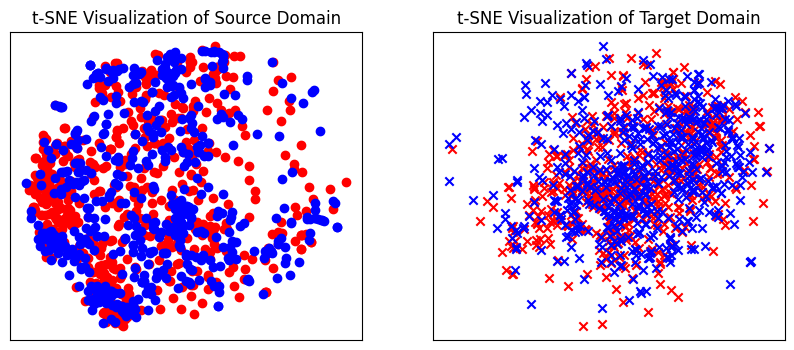

In [7]:
def tsne_visulization(source_data: np.ndarray, target_data: np.ndarray, path: str, format: str = 'jpg'):
    s = source_data.copy()
    t = target_data.copy()
    s = s.reshape(source_data.shape[0], -1)
    t = t.reshape(target_data.shape[0], -1)
    print(s.shape, t.shape)
    combined_dataset = np.vstack((s, t))
    print(combined_dataset.shape)

    perplexity = 30
    n_dimensions = 2

    tsne = TSNE(n_components=n_dimensions, perplexity=perplexity, random_state=42)
    tsne_result = tsne.fit_transform(combined_dataset)
    tsne_source_data = tsne_result[:s.shape[0]]
    tsne_target_data = tsne_result[s.shape[0]:]
    print(tsne_source_data.shape, tsne_target_data.shape)

    source_data_class0 = tsne_source_data[source_class0_index]
    source_data_class1 = tsne_source_data[source_class1_index]
    target_data_class0 = tsne_target_data[target_class0_index]
    target_data_class1 = tsne_target_data[target_class1_index]
    print(source_data_class0.shape, source_data_class1.shape, target_data_class0.shape, target_data_class1.shape)


    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.scatter(source_data_class0[:, 0], source_data_class0[:, 1], c='r', marker='o', label='source domain class 0')
    plt.scatter(source_data_class1[:, 0], source_data_class1[:, 1], c='b', marker='o', label='source domain class 1')
    plt.title('t-SNE Visualization of Source Domain')
    # plt.xlabel('t-SNE Dimension 1')
    # plt.ylabel('t-SNE Dimension 2')
    plt.xticks([])
    plt.yticks([])
    # plt.legend()

    plt.subplot(122)
    plt.scatter(target_data_class0[:, 0], target_data_class0[:, 1], c='r', marker='x', label='target domain class 0')
    plt.scatter(target_data_class1[:, 0], target_data_class1[:, 1], c='b', marker='x', label='target domain class 1')
    plt.title('t-SNE Visualization of Target Domain')
    # plt.xlabel('t-SNE Dimension 1')
    # plt.ylabel('t-SNE Dimension 2')
    plt.xticks([])
    plt.yticks([])
    # plt.legend()

    path = path + '.' + format
    plt.savefig(path, format=format)
    plt.show()

tsne_visulization(source_data.numpy(), val_data.numpy(), path='test.eps')

## 3.2 without DA

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


  0%|          | 1/500 [00:00<01:34,  5.29it/s]

Model saved at epoch 1 with validation accuracy: 0.5093


  0%|          | 2/500 [00:00<01:15,  6.61it/s]

Model saved at epoch 2 with validation accuracy: 0.5241


  1%|          | 4/500 [00:00<01:19,  6.21it/s]

Model saved at epoch 3 with validation accuracy: 0.5500
Model saved at epoch 4 with validation accuracy: 0.5824


  5%|▌         | 25/500 [00:02<00:47, 10.10it/s]

Model saved at epoch 24 with validation accuracy: 0.5852
Model saved at epoch 25 with validation accuracy: 0.5870


 18%|█▊        | 91/500 [00:09<00:40, 10.05it/s]

Model saved at epoch 90 with validation accuracy: 0.5907
Model saved at epoch 91 with validation accuracy: 0.5981


 19%|█▊        | 93/500 [00:09<00:40,  9.95it/s]

Model saved at epoch 92 with validation accuracy: 0.6056
Model saved at epoch 93 with validation accuracy: 0.6176


 20%|█▉        | 98/500 [00:10<00:40,  9.95it/s]

Model saved at epoch 97 with validation accuracy: 0.6250
Model saved at epoch 98 with validation accuracy: 0.6306


100%|██████████| 500/500 [00:51<00:00,  9.68it/s]


the best accuracy is:  0.6305555555555555


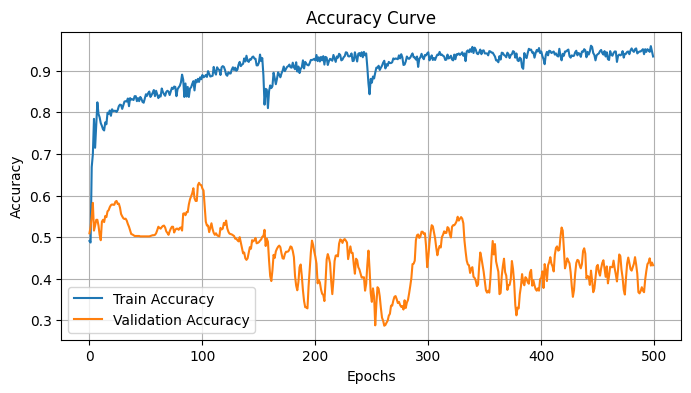

In [14]:
def test(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    correct = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred, features = model(x)
            correct += (torch.max(y_pred, 1)[1] == y).sum().item()

    accuracy = correct / size

    return accuracy, features



def train(source_data, source_label, val_data, val_label, target_data, target_label, batch_size=1080, epochs=500, lr=1e-3):
    train_dataset = TensorDataset(source_data, source_label)
    val_dataset = TensorDataset(val_data, val_label)
    test_dataset = TensorDataset(target_data, target_label)

    train_loader = DataLoader(dataset=train_dataset, batch_size=1080, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1080, shuffle=True)
    # test_loader = DataLoader(dataset=test_dataset, batch_size=1080, shuffle=True)

    model = EEGNet_ReLU(n_output=2)
    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(),lr = lr, weight_decay=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=5e-4)

    model.to(DEVICE)
    # summary(model.cuda(),(1,2,750))

    loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []

    best_acc = 0

    for epoch in tqdm(range(epochs)):
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        for batch, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()

            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred, source_features = model(x)

            loss = loss_fn(y_pred, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (torch.max(y_pred,1)[1] == y).sum().item()
            total += y.size(0)


        train_accuracy = correct / total
        train_accuracy_history.append(train_accuracy)

        val_accuracy, val_features = test(val_loader, model)
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), 'EEGNet_best_model.pth')
            print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_accuracy:.4f}')
            # test_acc, _ = test(test_loader, model)
            # print(f'test accuracy is {test_acc}')

        val_accuracy_history.append(val_accuracy)

        # print("epochs:",epoch,"loss:",loss.item(),"D_s Accuracy:",train_accuracy,"validation accuracy: ", val_accuracy, "D_t Accuracy:",test_accuracy)

    print("the best accuracy is: ", best_acc)
    model.load_state_dict(torch.load("EEGNet_best_model.pth"))
    _, source_features = model(source_data.to(DEVICE))
    _, val_features = model(val_data.to(DEVICE))
    # tsne_visulization(source_features.cpu().detach().numpy(), val_features.cpu().detach().numpy(), path='original.jpg')


    plt.figure(figsize=(8, 4))
    # plt.plot(loss_history, label="Loss")
    plt.plot(train_accuracy_history, label='Train Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    # plt.plot(test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.grid(True)
    plt.show()



source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
# val_data, val_label = source_data[-360:], source_label[-360:]
# source_data, source_label = source_data[:720], source_label[:720]
# print(source_data.shape, source_label.shape)
train(source_data, source_label, val_data, val_label, target_data, target_label, batch_size=1080, epochs=500, lr=1e-1)

## 3.3 With DA

In [58]:
def lr_lambda(epoch):
    if epoch < 100:
        return 0.1
    else:
        lr = 0.1 ** ((epoch // 100) + 1)
        return 1e-4 if lr < 1e-4 else lr


def test(data, label, model):
    model.eval()
    with torch.no_grad():
        data, label = data.to(DEVICE), label.to(DEVICE)
        pred, _, _, _ = model(data, data)

        correct_cnt = (torch.max(pred, 1)[1] == label).sum().item()
        sample_cnt = data.shape[0]
        accuracy = correct_cnt / sample_cnt

    return accuracy


def train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0.5, batch_size=1080, epochs=500, lr=1e-3, path='test', format='jpg'):
    train_dataset = TensorDataset(source_data, source_label)
    val_dataset = TensorDataset(val_data, val_label)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(),lr = lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=5e-4)
    lr_scheduler = LambdaLR(optimizer, lr_lambda)


    model.to(DEVICE)

    clf_loss_history = []
    mmd_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []

    best_acc = 0

    for epoch in tqdm(range(epochs)):
        model.train()

        optimizer.zero_grad()

        source_data, source_label = source_data.to(DEVICE), source_label.to(DEVICE)
        target_data = target_data.to(DEVICE)
        val_data = val_data.to(DEVICE)

        train_target_data = val_data
        train_target_data = train_target_data.to(DEVICE)

        preds, mmd_loss, source, val = model(source_data, train_target_data)

        # compute loss
        clf_loss = loss_fn(preds, source_label)
        loss = clf_loss + lambda_factor * mmd_loss

        clf_loss_history.append(loss.item())
        mmd_loss_history.append(mmd_loss.item())

        correct_cnt = (torch.max(preds, 1)[1]== source_label).sum().item()
        accuracy = correct_cnt / source_data.shape[0]
        train_accuracy_history.append(accuracy)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        val_accuracy = test(val_data, val_label, model)
        val_accuracy_history.append(val_accuracy)
        if val_accuracy > best_acc:
            best_acc = val_accuracy

            # torch.save(model.state_dict(), 'DA_best_model.pth')
            # print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_accuracy:.4f}')
            # print("LR: ", lr_scheduler.get_last_lr()[0], optimizer.state_dict()['param_groups'][0]['lr'])
            # if epoch > 100:
                # tsne_visulization(source.cpu().detach().numpy(), val.cpu().detach().numpy(), path='original.jpg')
        # print(f'classification loss: {clf_loss.item()}, discrepency: {mmd_loss.item()}')

        # if epoch == epochs - 1:
            # tsne_visulization(source.cpu().detach().numpy(), val.cpu().detach().numpy(), path='original.jpg')

    discrepency = np.mean(mmd_loss_history)

    # print("the best accuracy is: ", best_acc)
    # with torch.no_grad():
    #     model.load_state_dict(torch.load("DA_best_model.pth"))
    #     _, _, source_features, val_features = model(source_data.to(DEVICE), val_data.to(DEVICE))
    #     tsne_visulization(source_features.cpu().detach().numpy(), val_features.cpu().detach().numpy(), path='original.jpg')

    # plt.figure(figsize=(16, 4))
    # plt.subplot(1, 2, 1)
    # # plt.plot(loss_history, label="Loss")
    # plt.plot(train_accuracy_history, label='Train Accuracy')
    # plt.plot(val_accuracy_history, label='Validation Accuracy')
    # plt.plot(test_accuracy_history, label='Test Accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.title('Accuracy Curve')
    # plt.grid(True)
    # # plt.show()


    # plt.subplot(1, 2, 2)
    # plt.plot(clf_loss_history, label="CLF Loss")
    # plt.plot(mmd_loss_history, label='MMD Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title('Loss Curve')
    # plt.grid(True)
    # plt.show()

    print(f"lambda={lambda_factor}, accuracy={best_acc}, mean discrepency={discrepency}")

    return best_acc, discrepency


def main(model, path='demo.jpg'):
    lambda_list = []
    acc_list = []
    disc_list = []

    param_grid = {
        'lambda_factor': [0.001, 0.05, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 3, 5, 7, 10, 13, 15, 17, 20, 50, 70, 100], # 0.1, 0.3, 0.5, 0.7,
    }
    for params in ParameterGrid(param_grid):
        source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
        best_acc, discrepency = train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=params['lambda_factor'], batch_size=1080, epochs=500, lr=1e-2, path='DDC.jpg')
        model.apply(init_weights)

        lambda_list.append(params['lambda_factor'])
        acc_list.append(best_acc)
        disc_list.append(discrepency)

    return lambda_list, acc_list, disc_list


## DDC

In [59]:
# param_grid = {
#     'lambda_factor': [20, 50, 70, 100]
#     # 'lambda_factor': [0.1, 0.3, 0.5, 0.7, 0.9, 1, 3, 5, 7, 10, 100],
# }
# for params in ParameterGrid(param_grid):
model = EEGNet_DDC(num_classes=2)
lambda_list, acc_list, disc_list = main(model, path='DDC.jpg')
    # source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
    # train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=params['lambda_factor'], batch_size=1080, epochs=500, lr=1e-2, path='DDC.jpg')

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


lambda=0.001, accuracy=0.5981481481481481, mean discrepency=0.35983848094940185
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


lambda=0.05, accuracy=0.5944444444444444, mean discrepency=0.06334537696838378
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.81it/s]


lambda=0.01, accuracy=0.5898148148148148, mean discrepency=0.22775360298156738
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


lambda=0.1, accuracy=0.600925925925926, mean discrepency=0.0466496524810791
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


lambda=0.3, accuracy=0.5981481481481481, mean discrepency=0.033335948944091795
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.79it/s]


lambda=0.5, accuracy=0.6101851851851852, mean discrepency=0.025962188720703126
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.82it/s]


lambda=0.7, accuracy=0.5972222222222222, mean discrepency=0.022418100357055663
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.81it/s]


lambda=0.9, accuracy=0.5740740740740741, mean discrepency=0.018005649566650392
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.76it/s]


lambda=1, accuracy=0.5972222222222222, mean discrepency=0.018707738876342774
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


lambda=3, accuracy=0.6083333333333333, mean discrepency=0.011571388244628906
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


lambda=5, accuracy=0.600925925925926, mean discrepency=0.008533532619476319
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.77it/s]


lambda=7, accuracy=0.6259259259259259, mean discrepency=0.007857757568359375
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.74it/s]


lambda=10, accuracy=0.6101851851851852, mean discrepency=0.0077729330062866215
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.76it/s]


lambda=13, accuracy=0.5907407407407408, mean discrepency=0.007724770069122314
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.79it/s]


lambda=15, accuracy=0.6074074074074074, mean discrepency=0.005799803256988525
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.79it/s]


lambda=17, accuracy=0.6083333333333333, mean discrepency=0.0048774929046630855
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


lambda=20, accuracy=0.6166666666666667, mean discrepency=0.005086946964263916
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.77it/s]


lambda=50, accuracy=0.5277777777777778, mean discrepency=0.004822852730751038
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.81it/s]


lambda=70, accuracy=0.5444444444444444, mean discrepency=0.0037997936010360717
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:25<00:00, 19.81it/s]

lambda=100, accuracy=0.5370370370370371, mean discrepency=0.0028358603417873384


## with DA (DAN)

In [60]:
model = EEGNet_DAN(num_classes=2)
lambda_list, acc_list, disc_list = main(model, path='DAN.jpg')
# model = EEGNet_DAN(num_classes=2)
# source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
# train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0, batch_size=1080, epochs=200, lr=1e-2, path='DAN.jpg')
# 发现：加入MK-MMD(gaussian kernels)收敛会变困难?

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.29it/s]


lambda=0.001, accuracy=0.5916666666666667, mean discrepency=2.2838415381908415
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.28it/s]


lambda=0.05, accuracy=0.5787037037037037, mean discrepency=0.31375109958648684
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.30it/s]


lambda=0.01, accuracy=0.5675925925925925, mean discrepency=0.6718445855677128
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.29it/s]


lambda=0.1, accuracy=0.5990740740740741, mean discrepency=0.21795352040231228
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.30it/s]


lambda=0.3, accuracy=0.5648148148148148, mean discrepency=0.13935782285034656
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.30it/s]


lambda=0.5, accuracy=0.5787037037037037, mean discrepency=0.144993693202734
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.30it/s]


lambda=0.7, accuracy=0.5916666666666667, mean discrepency=0.1141502477824688
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.30it/s]


lambda=0.9, accuracy=0.600925925925926, mean discrepency=0.1295802302211523
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


lambda=1, accuracy=0.5342592592592592, mean discrepency=0.10092667406052351
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.29it/s]


lambda=3, accuracy=0.5194444444444445, mean discrepency=0.09206850707530975
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.30it/s]


lambda=5, accuracy=0.5194444444444445, mean discrepency=0.08796823536604644
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.28it/s]


lambda=7, accuracy=0.5518518518518518, mean discrepency=0.08971108078211545
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.30it/s]


lambda=10, accuracy=0.5805555555555556, mean discrepency=0.07619677148759366
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


lambda=13, accuracy=0.5148148148148148, mean discrepency=0.07692464470490813
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.29it/s]


lambda=15, accuracy=0.5148148148148148, mean discrepency=0.08113138183578848
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.29it/s]


lambda=17, accuracy=0.5481481481481482, mean discrepency=0.08100356028228999
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.28it/s]


lambda=20, accuracy=0.5092592592592593, mean discrepency=0.07680671580508351
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


lambda=50, accuracy=0.49537037037037035, mean discrepency=0.0654905062392354
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


lambda=70, accuracy=0.5435185185185185, mean discrepency=0.05777106374502182
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:32<00:00, 15.30it/s]

lambda=100, accuracy=0.512962962962963, mean discrepency=0.05867991519905627


### JAN

In [61]:
model = EEGNet_JAN(num_classes=2)
lambda_list, acc_list, disc_list = main(model, path='JAN.jpg')
# model = EEGNet_JAN(num_classes=2)
# source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
# train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0, batch_size=1080, epochs=200, lr=1e-2, path='JAN', format='jpg')

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.91it/s]


lambda=0.001, accuracy=0.5851851851851851, mean discrepency=1.9344677255153655
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.90it/s]


lambda=0.05, accuracy=0.6037037037037037, mean discrepency=0.15601340941189845
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.92it/s]


lambda=0.01, accuracy=0.6074074074074074, mean discrepency=0.2657752036275342
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.93it/s]


lambda=0.1, accuracy=0.6222222222222222, mean discrepency=0.1494177169662289
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.89it/s]


lambda=0.3, accuracy=0.6, mean discrepency=0.14358583059255034
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.92it/s]


lambda=0.5, accuracy=0.5833333333333334, mean discrepency=0.14733303970668932
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.94it/s]


lambda=0.7, accuracy=0.5685185185185185, mean discrepency=0.15383102768857498
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.89it/s]


lambda=0.9, accuracy=0.5944444444444444, mean discrepency=0.16565151688689367
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.93it/s]


lambda=1, accuracy=0.5722222222222222, mean discrepency=0.15479344254452734
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.91it/s]


lambda=3, accuracy=0.575, mean discrepency=0.15386102330347057
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.88it/s]


lambda=5, accuracy=0.5518518518518518, mean discrepency=0.16133187456429005
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.93it/s]


lambda=7, accuracy=0.5407407407407407, mean discrepency=0.13908983370492933
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.93it/s]


lambda=10, accuracy=0.5657407407407408, mean discrepency=0.13452832541699172
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.92it/s]


lambda=13, accuracy=0.5120370370370371, mean discrepency=0.1405372989658499
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.91it/s]


lambda=15, accuracy=0.5333333333333333, mean discrepency=0.1503117416164023
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.89it/s]


lambda=17, accuracy=0.5055555555555555, mean discrepency=0.1204699736161856
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.92it/s]


lambda=20, accuracy=0.55, mean discrepency=0.12426948327678838
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.88it/s]


lambda=50, accuracy=0.5092592592592593, mean discrepency=0.11346647097292589
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.93it/s]


lambda=70, accuracy=0.5564814814814815, mean discrepency=0.12192420242261141
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 500/500 [00:31<00:00, 15.89it/s]

lambda=100, accuracy=0.5296296296296297, mean discrepency=0.14876717600692063


# DJP-MMD

In [54]:
# MMD, JMMD, JPMMD, DJP-MMD
def mmd_loss(x_src, y_src, x_tar, y_pseudo, mmd_type):
    if mmd_type == 'mmd':
        return rbf_mmd(x_src, x_tar, SIGMA)
    elif mmd_type == 'jmmd':
        return rbf_jmmd(x_src, y_src, x_tar, y_pseudo, SIGMA)
    elif mmd_type == 'jpmmd':
        return rbf_jpmmd(x_src, y_src, x_tar, y_pseudo, SIGMA)
    elif mmd_type == 'djpmmd':
        return rbf_djpmmd(x_src, y_src, x_tar, y_pseudo, SIGMA)
    elif mmd_type == 'CS':
        return CS(x_src, x_tar, sigma=SIGMA)
    elif mmd_type == 'CCS':
        return CS(x_src, features_tar, sigma=SIGMA)  + CCS(x_src, x_tar, y_src.float(), y_pseudo.float(), sigma=SIGMA)

def test(data, label, model):
    model.eval()
    with torch.no_grad():
        data, label = data.to(DEVICE), label.to(DEVICE)
        pred, _, _ = model(data, data)

        correct_cnt = (torch.max(pred, 1)[1] == label).sum().item()
        sample_cnt = data.shape[0]
        accuracy = correct_cnt / sample_cnt

    return accuracy

def lr_lambda(epoch):
    if epoch < 100:
        return 0.1
    else:
        lr = 0.1 ** ((epoch // 100) + 1)
        return 1e-4 if lr < 1e-4 else lr


def train(model, source_data, source_label, val_data, val_label, target_data, target_label, mmd_type='djpmmd', lambda_factor=0.5, batch_size=1080, epochs=500, lr=1e-1, path='test', format='jpg'):
    train_dataset = TensorDataset(source_data, source_label)
    val_dataset = TensorDataset(val_data, val_label)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr = lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=5e-4)
    lr_scheduler = LambdaLR(optimizer, lr_lambda)

    model.to(DEVICE)

    # mmd_type = 'djpmmd'
    y_pse = torch.zeros(1080).long().cuda()

    clf_loss_history = []
    mmd_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []

    best_acc = 0

    for epoch in tqdm(range(epochs)):
        model.train()

        optimizer.zero_grad()

        source_data, source_label = source_data.to(DEVICE), source_label.to(DEVICE)
        # source_label.reshape(1080, 1)
        target_data = target_data.to(DEVICE)
        val_data, val_label = val_data.to(DEVICE), val_label.to(DEVICE)

        y_src, features_src, features_tar = model(source_data, val_data)
        # print("fshj", y_src.shape)
        # print(len(torch.unique(y_src)))

        # compute loss
        clf_loss = loss_fn(y_src, source_label)

        loss_mmd = mmd_loss(features_src, source_label.long(), features_tar, y_pse, mmd_type) # use true lable in the source domain to compute loss
        # loss_mmd = CS(features_src, features_tar, sigma=1, median_sigma=0)  + CCS(features_src, features_tar, source_label.float(), y_pse.float(), sigma=1, median_sigma=0)
        # loss_mmd = torch.tensor(0)
        # print('CS', CS(features_src, features_tar, sigma=1, median_sigma=0).item())
        # print('CCS', CCS(features_src, features_tar, source_label.float(), y_pse.float(), sigma=1, median_sigma=0).item())
        # print()
        # float(): RuntimeError: "dot" not implemented for 'Long', PyTorch 的 dot 函数不支持这种数据类型。dot 函数通常用于浮点数类型的张量，如 float32 或 float64

        loss = clf_loss + lambda_factor * loss_mmd
        # loss = clf_loss / lambda_factor + loss_mmd

        model.eval()
        y_pse, _, _ = model(val_data, val_data)
        y_pse = y_pse.detach().max(1)[1]

        clf_loss_history.append(loss.item())
        mmd_loss_history.append(loss_mmd.item())

        correct_cnt = (torch.max(y_src, 1)[1] == source_label).sum().item()
        accuracy = correct_cnt / source_data.shape[0]
        train_accuracy_history.append(accuracy)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()


        val_accuracy = test(val_data, val_label, model)
        val_accuracy_history.append(val_accuracy)
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            # torch.save(model.state_dict(), 'DA_best_model.pth')
            # print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_accuracy:.4f}')

            # print("LR: ", lr_scheduler.get_last_lr()[0], optimizer.state_dict()['param_groups'][0]['lr'])
        # print(f'classification loss: {clf_loss.item()}, discrepency: {loss_mmd.item()}')

    #     if epoch == epochs - 1:
    #         tsne_visulization(features_src.cpu().detach().numpy(), features_tar.cpu().detach().numpy(), path='original.jpg')


    # print("the best accuracy is: ", best_acc)
    # with torch.no_grad():
    #     model.load_state_dict(torch.load("DA_best_model.pth"))
    #     _, source_features, val_features = model(source_data.to(DEVICE), val_data.to(DEVICE))
    #     tsne_visulization(source_features.cpu().detach().numpy(), val_features.cpu().detach().numpy(), path='original.jpg')

    # plt.figure(figsize=(16, 4))
    # plt.subplot(1, 2, 1)
    # # plt.plot(loss_history, label="Loss")
    # plt.plot(train_accuracy_history, label='Train Accuracy')
    # plt.plot(val_accuracy_history, label='Validation Accuracy')
    # plt.plot(test_accuracy_history, label='Test Accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.title('Accuracy Curve')
    # plt.grid(True)
    # plt.show()


    # plt.subplot(1, 2, 2)
    # plt.plot(clf_loss_history, label="CLF Loss")
    # plt.plot(mmd_loss_history, label='MMD Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title('Loss Curve')
    # plt.grid(True)
    # plt.show()
    discrepency = np.nanmean(mmd_loss_history)
    print(f"lambda={lambda_factor}, accuracy={best_acc}, mean discrepency={discrepency}")

    return best_acc, discrepency


def main(model, mmd_type='djpmmd', path='demo.jpg'):
    lambda_list = []
    acc_list = []
    disc_list = []

    param_grid = {
        'lambda_factor': [ 0.001, 0.05, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 3, 5, 7, 10, 13, 15, 17, 20, 50, 70, 100], #
    }
    for params in ParameterGrid(param_grid):
        source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
        best_acc, discrepency = train(model, source_data, source_label, val_data, val_label, target_data, target_label, mmd_type='djpmmd', lambda_factor=params['lambda_factor'], batch_size=1080, epochs=200, lr=1e-2, path='DDC.jpg')
        model.apply(init_weights)
    return lambda_list, acc_list, disc_list

In [55]:
# LEARNING RATE FROM 1e-4 to 1e-1

model = EEGNet_DA1(n_output=2)
# model.apply(init_weights)
main(model, 'DJP-MMD')
# source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
# train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0, batch_size=1080, epochs=200, lr=1e-2, path='DJPMMD', format='jpg')

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.25it/s]


lambda=0.001, accuracy=0.5787037037037037, mean discrepency=0.002081270042981487
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.26it/s]


lambda=0.05, accuracy=0.5879629629629629, mean discrepency=0.0008575654905871488
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.29it/s]


lambda=0.01, accuracy=0.5814814814814815, mean discrepency=0.0008500602137064561
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.25it/s]


lambda=0.1, accuracy=0.5851851851851851, mean discrepency=0.0008431953261606395
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.25it/s]


lambda=0.3, accuracy=0.5981481481481481, mean discrepency=0.0008556038595270366
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.30it/s]


lambda=0.5, accuracy=0.587037037037037, mean discrepency=0.0008512167929438874
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.26it/s]


lambda=0.7, accuracy=0.5935185185185186, mean discrepency=0.0008533876980072819
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.28it/s]


lambda=0.9, accuracy=0.5935185185185186, mean discrepency=0.0008606409523054026
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.28it/s]


lambda=1, accuracy=0.5944444444444444, mean discrepency=0.0008489316568011418
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.26it/s]


lambda=3, accuracy=0.5925925925925926, mean discrepency=0.0008431385809672065
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.29it/s]


lambda=5, accuracy=0.5861111111111111, mean discrepency=0.0008532260154606774
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.29it/s]


lambda=7, accuracy=0.575925925925926, mean discrepency=0.0008381593597005121
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.25it/s]


lambda=10, accuracy=0.5842592592592593, mean discrepency=0.0008557457051938399
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.27it/s]


lambda=13, accuracy=0.5796296296296296, mean discrepency=0.0008625229794415645
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.28it/s]


lambda=15, accuracy=0.5740740740740741, mean discrepency=0.0008516338301706128
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.27it/s]


lambda=17, accuracy=0.5898148148148148, mean discrepency=0.0008501765094115399
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.32it/s]


lambda=20, accuracy=0.5953703703703703, mean discrepency=0.000853565135912504
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.27it/s]


lambda=50, accuracy=0.6083333333333333, mean discrepency=0.0008494825757225044
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.28it/s]


lambda=70, accuracy=0.575925925925926, mean discrepency=0.000847953702614177
torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


100%|██████████| 200/200 [00:13<00:00, 15.30it/s]

lambda=100, accuracy=0.5907407407407408, mean discrepency=0.0008376980249886401


([], [], [])

In [ ]:
torch.cuda.device_count()

1

## TCA

In [ ]:
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = K @ M @ K.T + self.lamb * np.eye(n_eye), K @ H @ K.T
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = A.T @ K
        Z /= np.linalg.norm(Z, axis=0)

        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)

        return acc, y_pred

    # TCA code is done here. You can ignore fit_new and fit_predict_new.

    def fit_new(self, Xs, Xt, Xt2):
        '''
        Map Xt2 to the latent space created from Xt and Xs
        :param Xs : ns * n_feature, source feature
        :param Xt : nt * n_feature, target feature
        :param Xt2: n_s, n_feature, target feature to be mapped
        :return: Xt2_new, mapped Xt2 with projection created by Xs and Xt
        '''
        # Computing projection matrix A from Xs an Xt
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot(
            [K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]

        # Compute kernel with Xt2 as target and X as source
        Xt2 = Xt2.T
        K = kernel(self.kernel_type, X1=Xt2, X2=X, gamma=self.gamma)

        # New target features
        Xt2_new = K @ A

        return Xt2_new

    def fit_predict_new(self, Xt, Xs, Ys, Xt2, Yt2):
        '''
        Transfrom Xt and Xs, get Xs_new
        Transform Xt2 with projection matrix created by Xs and Xt, get Xt2_new
        Make predictions on Xt2_new using classifier trained on Xs_new
        :param Xt: ns * n_feature, target feature
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt2: nt * n_feature, new target feature
        :param Yt2: nt * 1, new target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, _ = self.fit(Xs, Xt)
        Xt2_new = self.fit_new(Xs, Xt, Xt2)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt2_new)
        acc = sklearn.metrics.accuracy_score(Yt2, y_pred)

        return acc, y_pred


def train_valid(source_data, source_lable, val_data, val_label, target_data, target_label):

    source_data, val_data, target_data = source_data.reshape(source_data.shape[0], -1), val_data.reshape(val_data.shape[0], -1), target_data.reshape(target_data.shape[0], -1)

    # Create latent space and evaluate using Xs and Xt1
    tca = TCA(kernel_type='linear', dim=30, lamb=1, gamma=1)
    acc1, ypre1 = tca.fit_predict(source_data, source_label, val_data, val_label)

    # Project and evaluate Xt2 existing projection matrix and classifier
    acc2, ypre2 = tca.fit_predict_new(val_data, source_data, source_label, target_data, target_label)

    print(f'Accuracy of mapped source and target1 data : {acc1:.3f}')  # 0.800
    print(f'Accuracy of mapped target2 data            : {acc2:.3f}')  # 0.706




In [ ]:
train_valid(source_data, source_label, val_data, val_label, target_data, target_label)

In [ ]:
tca = TCA(kernel_type='linear', dim=30, lamb=1, gamma=1)
acc, ypred = tca.fit_predict(source_data, source_label, target_data, target_label)
print(f'Accuracy: {acc:.3f}')

## DaNN